# Motto. Генерация слогана для имени человека.

In [1]:
import torch
import json
from torch.utils.data import Dataset, DataLoader
from transformers import T5ForConditionalGeneration,T5Tokenizer
from transformers import GPT2LMHeadModel, GPT2Tokenizer

from torch.utils.tensorboard import SummaryWriter

from tqdm.auto import tqdm
import numpy as np

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
writer = SummaryWriter()

In [3]:
class NamesDataset(Dataset):
    def __init__(
        self,
        tokenizer: T5Tokenizer,
        data_path: str,
        max_length: int = 20,
        truncation: bool = True
    ) -> None:
        self.tokenizer = tokenizer
        self.truncation = truncation
        self.max_length = max_length
        
        with open(data_path, encoding="utf-8") as json_data:
            self.data = json.load(json_data)
        
    def __getitem__(self, index):
        name = self.data[index]["prompt"]
        body = self.data[index]["answer"]
        
        tokens = self.tokenizer(
            name,
            return_tensors='pt',
            padding="max_length",
            max_length=self.max_length,
            truncation=self.truncation
        )
        
        labels = self.tokenizer(
            body,
            return_tensors='pt',
            padding="max_length",
            max_length=self.max_length,
            truncation=self.truncation
        ).input_ids
        
        labels = labels.masked_fill_(labels == self.tokenizer.pad_token_id, -100) 
        
        return name, body, tokens.input_ids[0], tokens.attention_mask[0], labels[0]
    
    def __len__(self):
        return  len(self.data)

In [4]:
training_config = {
    "desc": "",
    "lr": 1e-3,
    "epoch_num": 10,
    "opt": "Adam",
    "batch_size": 5,
    "lr_decay": 0.8,
    "model_type": "T5",
    "model_size": "base"
}

In [5]:
if training_config["model_size"] not in ["large", "base", "small"]:
    raise ValueError("Wrong model size")

if training_config["model_type"] not in ["T5"]:
    raise ValueError("Wrong model type")

In [6]:
if training_config["model_type"] == "T5":
    model_name = "sberbank-ai/ruT5-" + training_config["model_size"]
    model = T5ForConditionalGeneration.from_pretrained(model_name).to(DEVICE)
    tokenizer = T5Tokenizer.from_pretrained(model_name)

In [7]:
dataset = NamesDataset(
    tokenizer=tokenizer,
    data_path="../data/dataset_v02.json",
    max_length=40
)

dataloader = DataLoader(dataset, batch_size=training_config["batch_size"], shuffle=True)

In [8]:
def test_work(name = None, beams = 1):
    _name, _, tokens_ids, tokens_attention, _ = dataset[np.random.randint(len(dataset))]
    
    if name is None:
        name = _name
    else:
        tokens = tokenizer(name, return_tensors='pt', padding="max_length", max_length = 40, truncation=True).to(DEVICE)
        tokens_ids = tokens.input_ids
        tokens_attention = tokens.attention_mask

    print(name)
    
    model.eval()
    output=model.generate(
        input_ids=tokens_ids.to(DEVICE).view(1, -1),
        attention_mask=tokens_attention.to(DEVICE).view(1, -1),
        num_beams=beams,
        num_return_sequences=beams,
        max_new_tokens = 40
    )
    
    phrase = "\n".join([slogan.split("</s>")[0] for slogan in tokenizer.batch_decode(output[:, 1:])])
    
    print(phrase)

In [9]:
test_work("Оля", beams=3)

Оля
<extra_id_0> ) ) ) ) )))))<extra_id_26> )<extra_id_27>)  Оддддддддддддддддддд
<extra_id_0> ) ) ) ) )))))<extra_id_26> )<extra_id_27>)  Одддддддддддддддддд.
<extra_id_0> ) ) ) ) )))))<extra_id_26> )<extra_id_27>)  Оддддддддддддддддддда


In [10]:
epoch_num = training_config["epoch_num"]
model.train()
opt = torch.optim.Adam(
    model.parameters(),
    lr=training_config["lr"]
)

lambda1 = lambda epoch: training_config["lr_decay"] ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lambda1)

In [11]:
iter_num = 0 
model.train()
for epoch in tqdm(range(epoch_num)):
    for _, _, tokens_ids, tokens_attention, labels in dataloader:
        model.zero_grad()
        
        output=model(
            input_ids=tokens_ids.to(DEVICE),
            attention_mask=tokens_attention.to(DEVICE),
            labels=labels.to(DEVICE)
        )
        
        output["loss"].backward()
        
        loss_value = output.loss.detach().cpu().item()
        writer.add_scalar(f"Loss {training_config=}", loss_value, iter_num)
        opt.step()
        iter_num += 1
    
    scheduler.step()

  0%|          | 0/10 [00:00<?, ?it/s]

График ф-ции потерь:

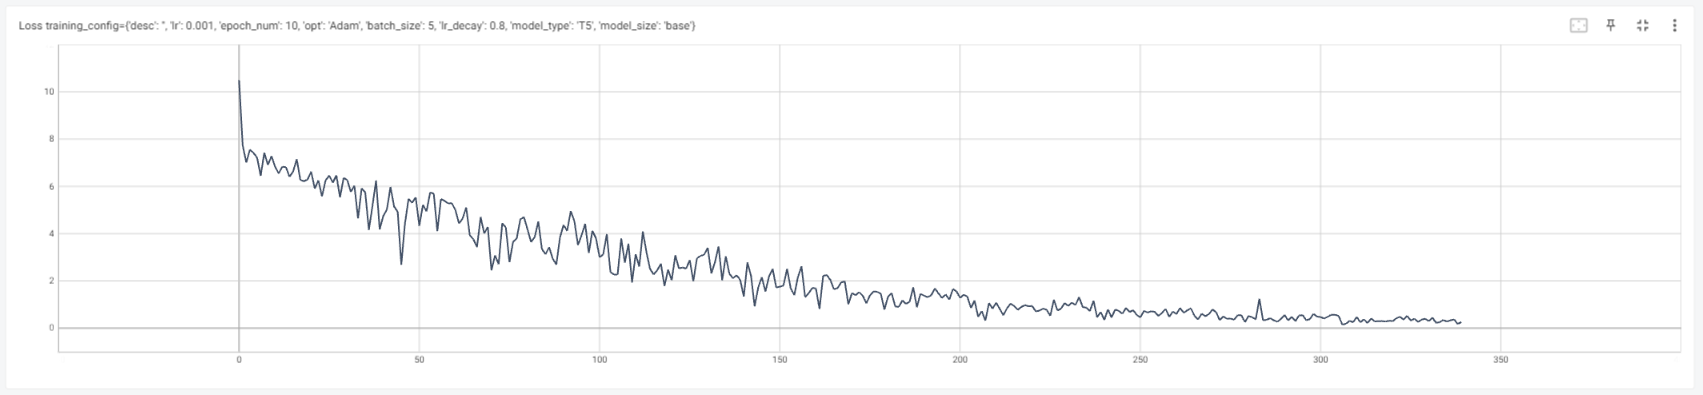

## Пример работы на именах из датасета

In [12]:
test_work("Никита", beams=3)

Никита
Никита — значит «победитель». Способен Ангел — твой хранитель Тебя к победам привести. Вперед! И доброго пути!
Никита — значит «победитель». Способен Ангел — твой хранитель Тебя к победам привести. Способен Ангел — твой хранитель Тебя к победам привести.
Никита — значит «победитель». Способен Ангел — твой хранитель Тебя к победам привести.


In [13]:
test_work("Максим", beams=3)

Максим
Если вас зовут Максим – также он необходим.
Если вас зовут Максим – также он необходим. Опыта багаж начальный Пусть послужит хорошо.
Если вас зовут Максим — также он необходим. Опыта багаж начальный Пусть послужит хорошо.


## Пример работы на именах, не из обучаемых данных

In [14]:
test_work("Парвиз", beams=3)

Парвиз
Если ваше имя Парва — поищи себе другого.
Если ваше имя Парва — это повод вставить грубо.
Если ваше имя Парва — это повод вставить справа.


In [15]:
test_work("Рустам", beams=3)

Рустам
У Руса — сплошные романы, Жизнь как повесть, клубок авантюр. Его другом стал вечный странник, Златокудрый мальчишка Амур.
Если ваше имя Руса — то оно в штанине — справа.
Если ваше имя Руса — то никак без вазелина.
